<a href="https://colab.research.google.com/github/seepala98/EVA-4/blob/master/PHASE_1/S7/FINAL_CIFAR_10_S7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Packages
The following packages need to be installed before running the code below
- torchsummary

In [1]:
!pip install torchsummary

# Imports
Importing necessary packages

In [0]:
%matplotlib inline

import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from tqdm import tqdm
from torchvision import datasets, transforms
from torchsummary import summary

# Dataset Preparation and Loading
The following steps are performed for preparing the dataset for the model.
- Downloading the CIFAR-10 dataset
- Visualizing the dataset
- Defining data transformations
- Splitting the dataset into train and validation set
- Creating data loader for train and validation set

## Data Visualization
Let's see how our data looks like. This information will help us decide the transformations that can be used on the dataset.


Extracting ./data/cifar-10-python.tar.gz to ./data


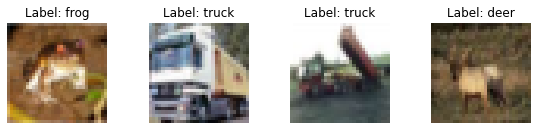

In [3]:
# Download data
cifar_dataset = datasets.CIFAR10('./data', train=True, download=True)
sample_data, sample_targets = cifar_dataset.data, cifar_dataset.targets

# Define classes of CIFAR dataset
classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)

# Set number of images to display
num_images = 4

# Display images with labels
fig, axs = plt.subplots(1, 4, figsize=(8, 8))
fig.tight_layout()

for i in range(num_images):
    axs[i].axis('off')
    axs[i].set_title(f'Label: {classes[sample_targets[i]]}')
    axs[i].imshow(sample_data[i])

## Data Transformations

The following transformations will be used
- ToTensor
- Normalize

In [0]:
# Train phase transformations
train_transforms = transforms.Compose([
    # convert the data to torch.FloatTensor with values within the range [0.0 ,1.0]
    transforms.ToTensor(),

    # normalize the data with mean and standard deviation to keep values in range [-1, 1]
    # since there are 3 channels for each image,
    # we have to specify mean and std for each channel
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Validation phase transformations
val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

## Train Data and Validation Data Split
The data is downloaded and split into two sets: train and validation

In [5]:
train_data = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
val_data = datasets.CIFAR10('./data', train=False, download=True, transform=val_transforms)

Files already downloaded and verified
Files already downloaded and verified


## Training and Validation Dataloaders
This is the final step in data preparation. It sets the dataloader arguments and then creates the dataloader

In [6]:
SEED = 1

cuda = torch.cuda.is_available()
print('CUDA Available?', cuda)

# For reproducibility of results
torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64, num_workers=2)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# validation dataloader
val_loader = torch.utils.data.DataLoader(val_data, **dataloader_args)

CUDA Available? True


# Model Architecture
Designing the model structure

In [0]:
class Net(nn.Module):
    def __init__(self):
        """ This function instantiates all the model layers """
        super(Net, self).__init__()

        dropout_rate = 0.05

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),  # 32,3 | 32,32 | 3x3
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_rate),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),  # 32,32 | 32,64 | 5x5
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_rate)
        )

        self.transblock1 = nn.Sequential(
            nn.MaxPool2d(2, 2),  # 32,64 | 16,64 | 6x6
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1)  # 16,64 | 16,32 | 6x6
        )

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),  # 16,32 | 16,32 | 10x10
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_rate),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),  # 16,32 | 16,64 | 14x14
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_rate)
        )

        self.transblock2 = nn.Sequential(
            nn.MaxPool2d(2, 2),  # 16,64 | 8,64 | 16x16
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1)  # 8,64 | 8,32 | 16x16
        )

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),  # 8,32 | 8,2 | 24x24
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_rate),

            # Depthwise separable convolution
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, groups=32, padding=1),  # 8,32 | 8,32 | 32x32
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1),  # 8,32 | 8,64 | 32x32
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_rate)
        )

        self.transblock3 = nn.Sequential(
            nn.MaxPool2d(2, 2),  # 8,64 | 4,64 | 36x36
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1)  # 4x,4 | 4,32 | 36x36
        )

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),  # 4,32 | 4,32 | 52x52
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_rate),

            # Dilated convolution
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, dilation=2),  # 4,32 | 4,64 | 84x84
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_rate)
        )

        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(1)
        )  # 4,64 | 1,64

        self.fc = nn.Sequential(
            nn.Linear(64, 10)
        )
    
    def forward(self, x):
        """ This function defines the network structure """
        x = self.convblock1(x)
        x = self.transblock1(x)
        x = self.convblock2(x)
        x = self.transblock2(x)
        x = self.convblock3(x)
        x = self.transblock3(x)
        x = self.convblock4(x)
        x = self.gap(x)
        x = x.view(-1, 64)
        x = self.fc(x)
        return x

In [8]:
device = torch.device("cuda" if cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,496
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
         MaxPool2d-9           [-1, 64, 16, 16]               0
           Conv2d-10           [-1, 32, 16, 16]           2,080
           Conv2d-11           [-1, 32, 16, 16]           9,248
             ReLU-12           [-1, 32, 16, 16]               0
      BatchNorm2d-13           [-1, 32, 16, 16]              64
          Dropout-14           [-1, 32,

# Model Training and Validation

Function for model training

In [0]:
def train(model, train_loader, device, optimizer, criterion):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar, 0):
        # Get samples
        data, target = data.to(device), target.to(device)

        # Set gradients to zero before starting backpropagation
        optimizer.zero_grad()

        # Predict output
        y_pred = model(data)

        # Calculate loss
        loss = criterion(y_pred, target)

        # Perform backpropagation
        loss.backward()
        optimizer.step()

        # Update progress bar
        pred = y_pred.argmax(dim=1, keepdim=False)
        correct += pred.eq(target).sum().item()
        processed += len(data)
        pbar.set_description(desc=f'Loss={loss.item():0.2f} Batch ID={batch_idx} Accuracy={(100 * correct / processed):.2f}')

Function for model validation

In [0]:
def val(model, val_loader, device, criterion, losses, accuracies):
    model.eval()
    correct = 0
    val_loss = 0
    with torch.no_grad():
        for data, target in val_loader:
            img_batch = data  # This is done to keep data in CPU
            data, target = data.to(device), target.to(device)  # Get samples
            output = model(data)  # Get trained model output
            val_loss += criterion(output, target).item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=False)  # Get the index of the max log-probability

            correct += pred.eq(target).sum().item()
    
    val_loss /= len(val_loader.dataset)
    losses.append(val_loss)
    accuracies.append(100. * correct / len(val_loader.dataset))
    print(f'\nValidation set: Average loss: {val_loss:.4f}, Accuracy: {correct}/{len(val_loader.dataset)} ({accuracies[-1]:.2f}%)\n')

Function for model execution

In [11]:
losses = []
accuracies = []

model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.95)
epochs = 50

for epoch in range(1, epochs + 1):
    print(f'Epoch {epoch}:')
    train(model, train_loader, device, optimizer, criterion)
    val(model, val_loader, device, criterion, losses, accuracies)

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0086, Accuracy: 6121/10000 (61.21%)

Epoch 2:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0071, Accuracy: 6874/10000 (68.74%)

Epoch 3:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0062, Accuracy: 7270/10000 (72.70%)

Epoch 4:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0058, Accuracy: 7449/10000 (74.49%)

Epoch 5:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0056, Accuracy: 7521/10000 (75.21%)

Epoch 6:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0051, Accuracy: 7758/10000 (77.58%)

Epoch 7:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0048, Accuracy: 7896/10000 (78.96%)

Epoch 8:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0047, Accuracy: 7901/10000 (79.01%)

Epoch 9:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0047, Accuracy: 7985/10000 (79.85%)

Epoch 10:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0045, Accuracy: 8076/10000 (80.76%)

Epoch 11:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0044, Accuracy: 8120/10000 (81.20%)

Epoch 12:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0047, Accuracy: 7978/10000 (79.78%)

Epoch 13:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0044, Accuracy: 8108/10000 (81.08%)

Epoch 14:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0043, Accuracy: 8191/10000 (81.91%)

Epoch 15:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0045, Accuracy: 8148/10000 (81.48%)

Epoch 16:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0042, Accuracy: 8216/10000 (82.16%)

Epoch 17:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0043, Accuracy: 8240/10000 (82.40%)

Epoch 18:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0044, Accuracy: 8154/10000 (81.54%)

Epoch 19:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0043, Accuracy: 8230/10000 (82.30%)

Epoch 20:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0043, Accuracy: 8279/10000 (82.79%)

Epoch 21:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0043, Accuracy: 8242/10000 (82.42%)

Epoch 22:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0043, Accuracy: 8250/10000 (82.50%)

Epoch 23:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0044, Accuracy: 8243/10000 (82.43%)

Epoch 24:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0042, Accuracy: 8306/10000 (83.06%)

Epoch 25:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0042, Accuracy: 8295/10000 (82.95%)

Epoch 26:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0043, Accuracy: 8296/10000 (82.96%)

Epoch 27:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0044, Accuracy: 8289/10000 (82.89%)

Epoch 28:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0043, Accuracy: 8303/10000 (83.03%)

Epoch 29:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0044, Accuracy: 8291/10000 (82.91%)

Epoch 30:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0043, Accuracy: 8358/10000 (83.58%)

Epoch 31:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0045, Accuracy: 8240/10000 (82.40%)

Epoch 32:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0043, Accuracy: 8323/10000 (83.23%)

Epoch 33:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0042, Accuracy: 8355/10000 (83.55%)

Epoch 34:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0044, Accuracy: 8356/10000 (83.56%)

Epoch 35:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0043, Accuracy: 8365/10000 (83.65%)

Epoch 36:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0044, Accuracy: 8366/10000 (83.66%)

Epoch 37:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0049, Accuracy: 8269/10000 (82.69%)

Epoch 38:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0045, Accuracy: 8285/10000 (82.85%)

Epoch 39:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0045, Accuracy: 8324/10000 (83.24%)

Epoch 40:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0046, Accuracy: 8317/10000 (83.17%)

Epoch 41:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0044, Accuracy: 8385/10000 (83.85%)

Epoch 42:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0044, Accuracy: 8384/10000 (83.84%)

Epoch 43:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0044, Accuracy: 8376/10000 (83.76%)

Epoch 44:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0046, Accuracy: 8357/10000 (83.57%)

Epoch 45:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0046, Accuracy: 8363/10000 (83.63%)

Epoch 46:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0045, Accuracy: 8340/10000 (83.40%)

Epoch 47:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0045, Accuracy: 8357/10000 (83.57%)

Epoch 48:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0047, Accuracy: 8346/10000 (83.46%)

Epoch 49:


  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0046, Accuracy: 8365/10000 (83.65%)

Epoch 50:


Loss=0.11 Batch ID=390 Accuracy=93.63: 100%|██████████| 391/391 [00:14<00:00, 27.19it/s]



Validation set: Average loss: 0.0046, Accuracy: 8350/10000 (83.50%)



## Plotting Results
Plotting changes in validation loss and accuracy obtained during model training.

In [0]:
def plot_metric(values, metric):
    # Initialize a figure
    fig = plt.figure(figsize=(7, 5))

    # Plot values
    plt.plot(values)

    # Set plot title
    plt.title(f'Validation {metric}')

    # Label axes
    plt.xlabel('Epoch')
    plt.ylabel(metric)

    # Set legend
    location = 'upper' if metric == 'Loss' else 'lower'

    # Save plot
    fig.savefig(f'{metric.lower()}_change.png')

Plot changes in validation loss

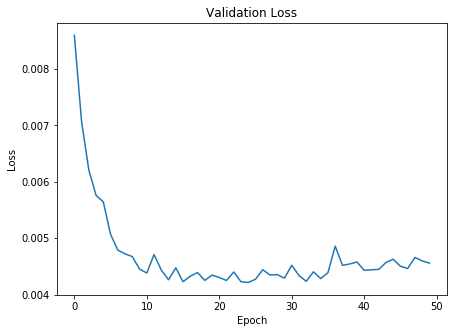

In [13]:
plot_metric(losses, 'Loss')

Plot changes in validation accuracy

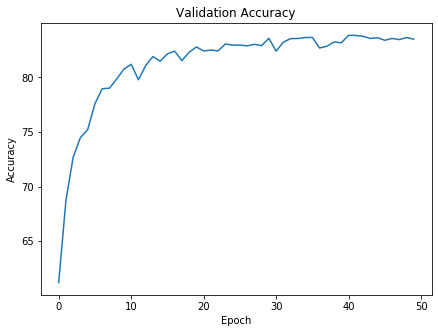

In [14]:
plot_metric(accuracies, 'Accuracy')

## Result Analysis

Displaying accuracy for each class in the entire validation dataset

In [16]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for _, (images, labels) in enumerate(val_loader, 0):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 85 %
Accuracy of   car : 91 %
Accuracy of  bird : 73 %
Accuracy of   cat : 74 %
Accuracy of  deer : 84 %
Accuracy of   dog : 72 %
Accuracy of  frog : 88 %
Accuracy of horse : 86 %
Accuracy of  ship : 92 %
Accuracy of truck : 86 %
